In [59]:
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
import glob
import dotenv
import torch
from tqdm.auto import tqdm
import json
from nomic import atlas
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from matplotlib import colors as mplcolors
import sklearn.manifold
import sklearn.neighbors
import sklearn.gaussian_process
import sklearn.linear_model
import sklearn.preprocessing
import colorcet as cc
import shapely.geometry
import shapely.ops
import cv2 as cv

dotenv.load_dotenv()

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

## Embed sentences


In [ ]:
model_path = "Alibaba-NLP/gte-large-en-v1.5"
tokenizer = AutoTokenizer.from_pretrained(model_path)
embedding_model = AutoModel.from_pretrained(model_path, trust_remote_code=True).to(device)
embedding_model.eval()

sentences = []
speakers = []

for transcript_file_path in glob.glob("speaker_transcripts/*.txt"):
    speaker = transcript_file_path.split("/")[-1].split(".")[0]
    with open(transcript_file_path, "r") as f:
        speaker_sentences = f.readlines()
    speaker_sentences = [sentence.strip() for sentence in speaker_sentences]
    sentences += speaker_sentences
    speakers += [speaker] * len(speaker_sentences)

embeddings = torch.zeros(len(sentences), 1024).to(device)

batch_size = 1024
with torch.no_grad():
    embedding_model_inputs = tokenizer(sentences, max_length=8192, padding=True, truncation=True, return_tensors="pt")
    embedding_model_inputs = embedding_model_inputs.to(device)
    for start_index in tqdm(range(0, len(sentences), batch_size), desc="Embedding sentences"):
        end_index = min(start_index + batch_size, len(sentences))
        input_ids = embedding_model_inputs.input_ids[start_index:end_index]
        attention_mask = embedding_model_inputs.attention_mask[start_index:end_index]
        token_type_ids = embedding_model_inputs.token_type_ids[start_index:end_index]
        embeddings[start_index:end_index] = embedding_model(
            input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
        ).last_hidden_state[:, 0]
        embeddings[start_index:end_index] = F.normalize(embeddings[start_index:end_index], p=2, dim=1)

documents = []
for i in range(len(sentences)):
    documents.append(
        {
            "id": hash(sentences[i]),
            "speaker": speakers[i],
            "sentence": sentences[i],
            "embedding": embeddings[i].cpu().numpy().tolist(),
        }
    )

with open("sentences.jsonl", "w") as f:
    text = "\n".join([json.dumps(record) for record in documents])
    f.write(text)

## Project embeddings to 2D


In [193]:
with open("sentences.jsonl", "r") as f:
    documents = [json.loads(line) for line in f.readlines()]
    for document in documents:
        document["embedding"] = np.array(document["embedding"])

documents = [document for document in documents if document["speaker"] != "RuPaul"]

In [194]:
embeddings = np.array([document["embedding"] for document in documents])
speaker_feature = [document["speaker"] for document in documents]

projection_model = sklearn.neighbors.NeighborhoodComponentsAnalysis(n_components=2, random_state=0, verbose=1)
projection = projection_model.fit_transform(embeddings, speaker_feature)

Finding most discriminative components... done in  2.00s
[NeighborhoodComponentsAnalysis]
[NeighborhoodComponentsAnalysis]  Iteration      Objective Value    Time(s)
[NeighborhoodComponentsAnalysis] ------------------------------------------
[NeighborhoodComponentsAnalysis]          1         9.937396e+02       0.49
[NeighborhoodComponentsAnalysis]          1         1.000990e+03       0.29
[NeighborhoodComponentsAnalysis]          2         1.024879e+03       0.26
[NeighborhoodComponentsAnalysis]          3         1.042031e+03       0.30
[NeighborhoodComponentsAnalysis]          4         1.057962e+03       0.33
[NeighborhoodComponentsAnalysis]          5         1.071840e+03       0.25
[NeighborhoodComponentsAnalysis]          6         1.081714e+03       0.44
[NeighborhoodComponentsAnalysis]          7         1.096061e+03       0.29
[NeighborhoodComponentsAnalysis]          8         1.103651e+03       0.28
[NeighborhoodComponentsAnalysis]          9         1.120249e+03       0.2

/Users/isaac/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_nca.py:335: ConvergenceWarning: [NeighborhoodComponentsAnalysis] NCA did not converge: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  warn(


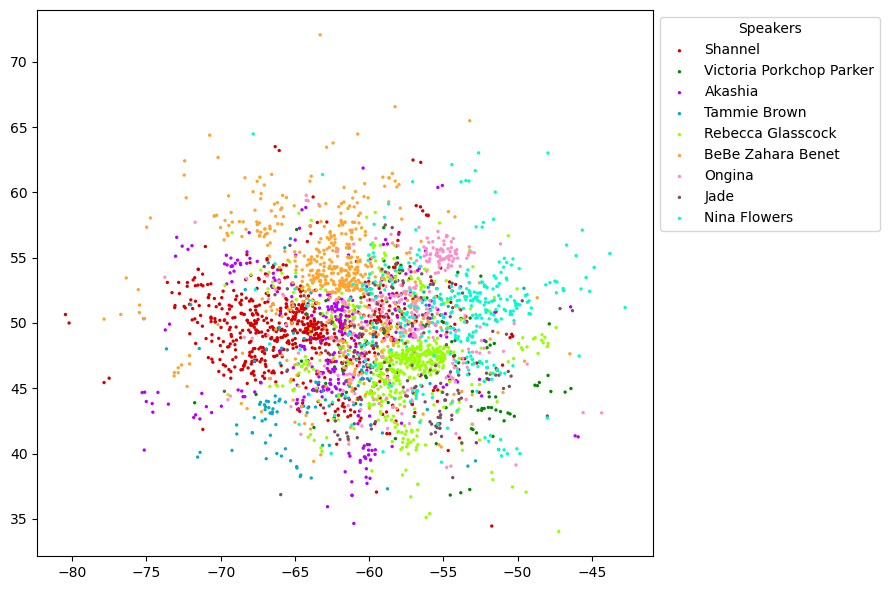

In [299]:
speakers = list(set([document["speaker"] for document in documents]))
plt.figure(figsize=(9, 6))
cmap = cc.glasbey_light
for speaker in speakers:
    indices = [i for i in range(len(speaker_feature)) if speaker_feature[i] == speaker]
    plt.scatter(
        projection[indices, 0], projection[indices, 1], label=speaker, c=[cmap[speakers.index(speaker)] for i in indices], s=2
    )
plt.legend(title="Speakers", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Calculate density in embedding space


In [308]:
def density_model(points):
    x, y = points.T
    bandwidth = np.mean(np.std(points, axis=0))
    xy_train = np.vstack([y, x]).T
    kde_skl = sklearn.neighbors.KernelDensity(bandwidth=bandwidth, kernel="linear")
    kde_skl.fit(xy_train)
    return kde_skl


def calculate_density(points, resolution=(100, 100)):
    xbins, ybins = resolution
    xbins = complex(0, xbins)
    ybins = complex(0, ybins)
    x, y = points.T
    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min() : x.max() : xbins, y.min() : y.max() : ybins]
    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    kde_skl = density_model(points)
    z = np.exp(kde_skl.score_samples(xy_sample))
    z -= z.min()
    z /= z.max()
    return xx, yy, np.reshape(z, xx.shape)


def blob_from_density(density, size=(6, 4), dpi=300, threshold=0.8):
    xx, yy = np.meshgrid(np.linspace(-1, 1, density.shape[1]), np.linspace(-1, 1, density.shape[0]))
    cmap = mplcolors.ListedColormap([(1, 0, 0, 1), (0, 0, 0, 1), (1, 1, 1, 1)])
    fig = plt.figure(figsize=size, dpi=dpi)
    plt.contourf(xx, yy, density, cmap=cmap, levels=[0, threshold], origin="lower")

    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().set_frame_on(False)
    fig.tight_layout(pad=0)

    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    mask = data[:, :, 0] > 0
    plt.close(fig)
    return mask


def style_blob(blob, color=None, opacity=0.75, outline=3):
    if color is None:
        color = np.random.rand(3)
    elif type(color) == str:
        color = mplcolors.to_rgb(color)
    imgray = blob.astype(np.uint8) * 255
    ret, thresh = cv.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    imcolor = imgray[:, :, np.newaxis].repeat(4, 2)
    color_int = [int(255 * x) for x in color]
    imcolor[np.where(imcolor[:, :, 0] == 255)] = [color_int[0], color_int[1], color_int[2], int(255 * opacity)]
    cv.drawContours(imcolor, contours, -1, (color_int[0], color_int[1], color_int[2], 255), outline)
    return imcolor

  0%|          | 0/9 [00:00<?, ?it/s]

Shannel


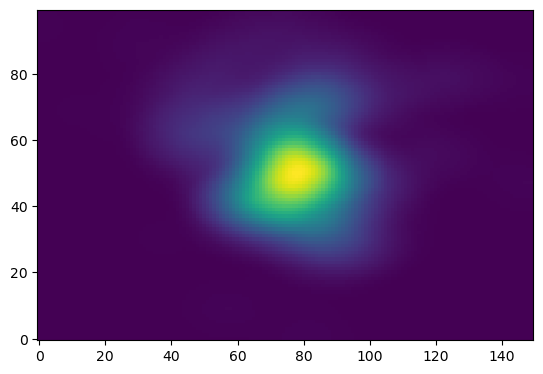

Victoria Porkchop Parker


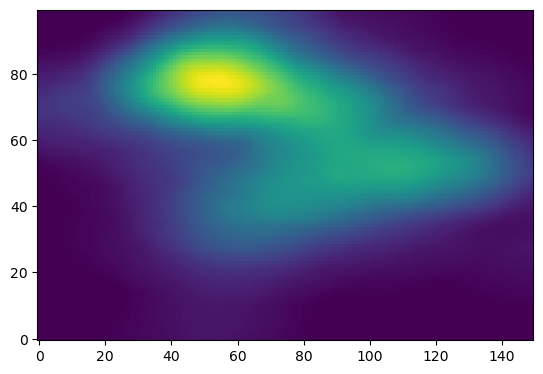

Akashia


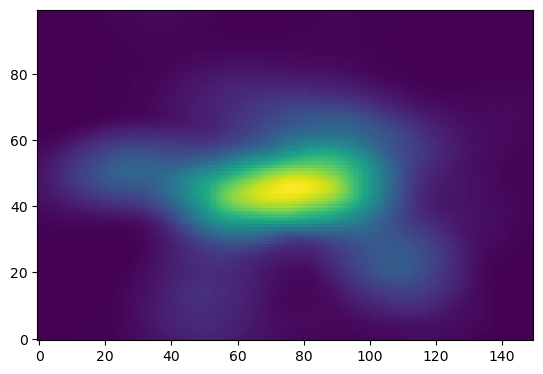

Tammie Brown


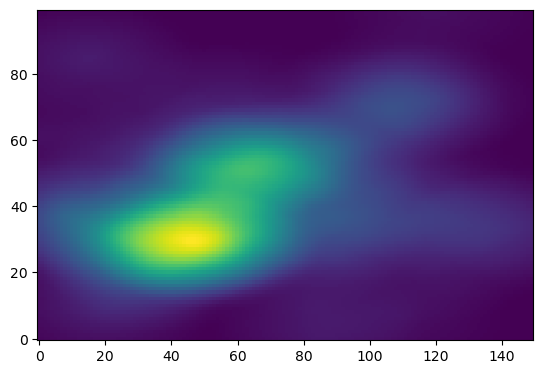

Rebecca Glasscock


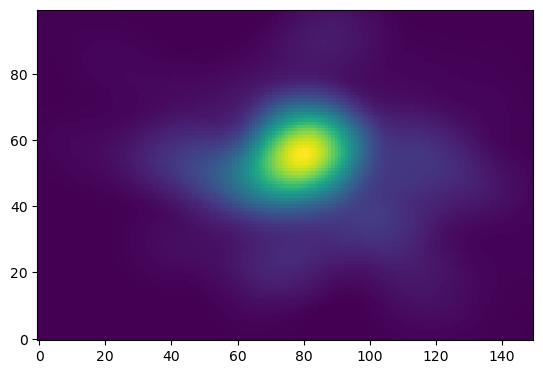

BeBe Zahara Benet


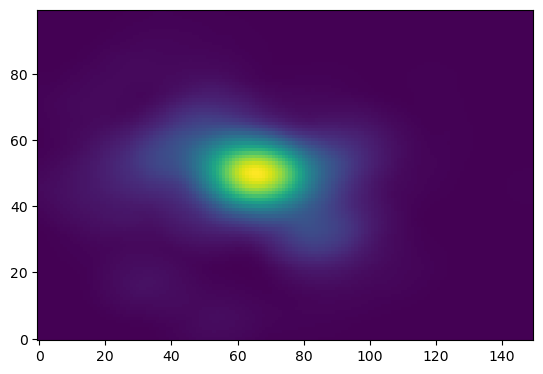

Ongina


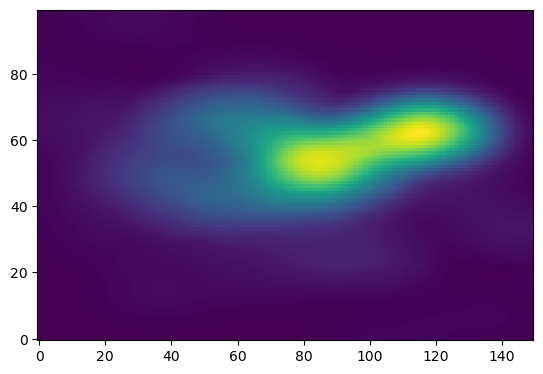

Jade


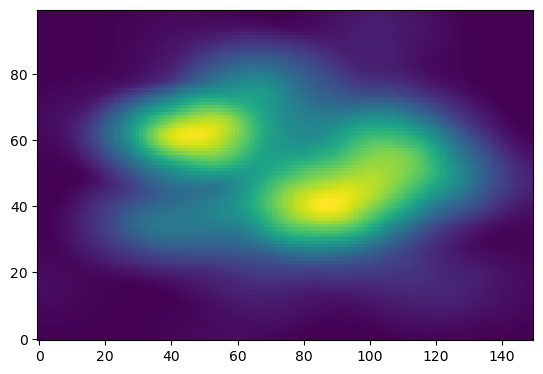

Nina Flowers


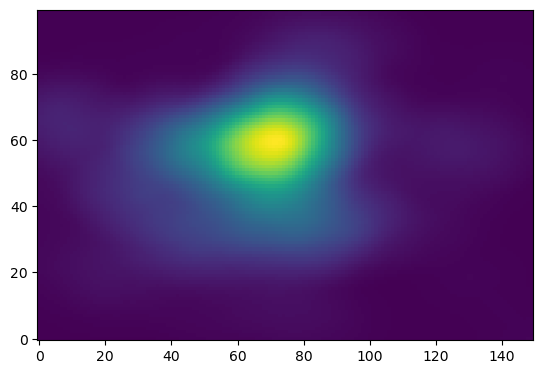

In [309]:
base_resolution = (100, 150)

speaker_densities = {}
for speaker in tqdm(speakers):
    print(speaker)
    speaker_document_indices = [i for i, document in enumerate(documents) if document["speaker"] == speaker]
    speaker_projections = projection[speaker_document_indices]
    xx, yy, density = calculate_density(speaker_projections, resolution=base_resolution)
    speaker_densities[speaker] = density
    plt.imshow(density, origin="lower")
    plt.show()

## Analyze overlap in projected space


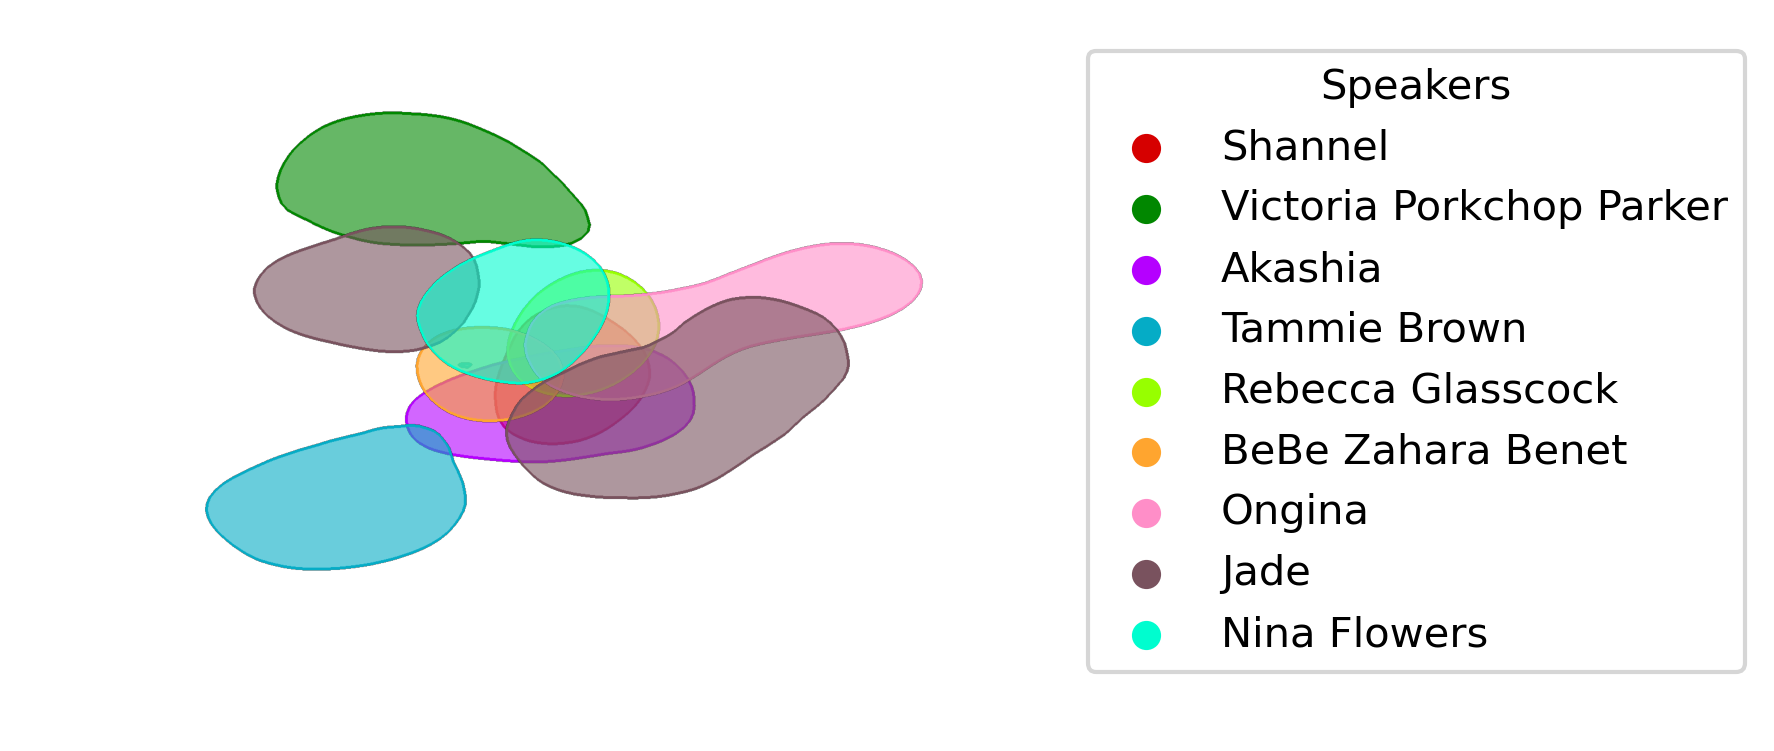

In [342]:
threshold = 0.7

cmap = cc.glasbey_light
plt.figure(figsize=(6, 4), dpi=300)
for i, speaker in enumerate(speakers):
    density = speaker_densities[speaker]
    blob = blob_from_density(density, threshold=threshold)
    blob = style_blob(blob, color=cmap[i], opacity=0.6, outline=3)
    plt.scatter([], [], color=cmap[i], label=speaker)
    plt.imshow(blob)

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.gca().set_frame_on(False)
plt.legend(
    title="Speakers",
    loc="upper left",
    bbox_to_anchor=(1, 1),
)
plt.tight_layout()
plt.show()

/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_19416/3333629096.py:8: RuntimeWarning: divide by zero encountered in log
  pairwise_matrix[i, j] = -np.log(mse)


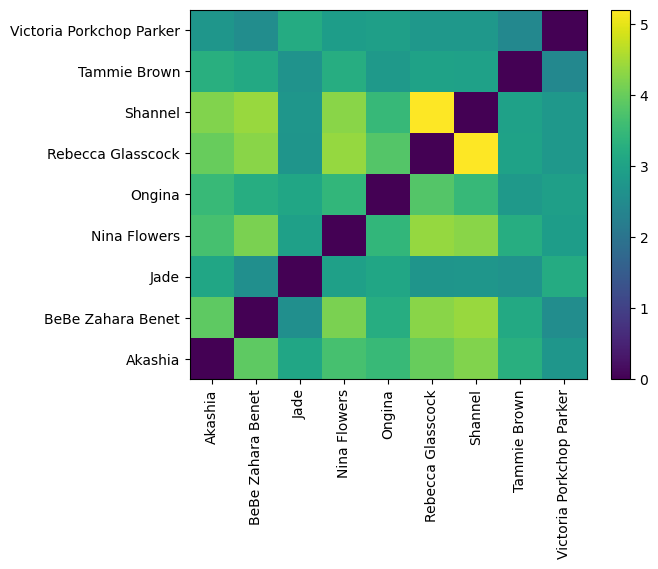

Most distinctive queens (verbally):
Victoria Porkchop Parker
Jade

Least distinctive queens (verbally):
Shannel
Rebecca Glasscock

Most similar pairs of queens (verbally):
('Rebecca Glasscock', 'Shannel')
('BeBe Zahara Benet', 'Shannel')

Most dissimilar pairs of queens (verbally):
('Tammie Brown', 'Victoria Porkchop Parker')
('BeBe Zahara Benet', 'Victoria Porkchop Parker')


In [343]:
pairwise_matrix = np.zeros((len(speakers), len(speakers)))

for i in range(len(speakers)):
    speaker_1 = speakers[i]
    for j in range(len(speakers)):
        speaker_2 = speakers[j]
        mse = ((speaker_densities[speaker_1] - speaker_densities[speaker_2]) ** 2).mean()
        pairwise_matrix[i, j] = -np.log(mse)
        if i == j:
            pairwise_matrix[i, j] = 0


alpha_order = np.argsort(speakers)
sorted_speakers = np.array([speakers[i] for i in alpha_order])
pairwise_matrix = pairwise_matrix[alpha_order][:, alpha_order]


plt.pcolormesh(pairwise_matrix, cmap="viridis")
plt.xticks(np.arange(len(speakers)) + 0.5, sorted_speakers, rotation=90)
plt.yticks(np.arange(len(speakers)) + 0.5, sorted_speakers)
plt.colorbar()
plt.show()

order_by_mean_jaccard = np.argsort(pairwise_matrix.mean(axis=1))
speakers_sorted_by_mean_jaccard = sorted_speakers[order_by_mean_jaccard]
top_portion = 0.25
top_k = max(1, int(top_portion * len(sorted_speakers)))

print("Most distinctive queens (verbally):")
for speaker in speakers_sorted_by_mean_jaccard[:top_k]:
    print(speaker)
print()

print("Least distinctive queens (verbally):")
for speaker in speakers_sorted_by_mean_jaccard[-top_k:]:
    print(speaker)
print()


x, y = np.meshgrid(
    np.linspace(0, len(sorted_speakers) - 1, len(sorted_speakers)),
    np.linspace(0, len(sorted_speakers) - 1, len(sorted_speakers)),
)
coords = np.vstack([x.ravel(), y.ravel()]).T
coords = coords[coords[:, 0] < coords[:, 1]]
similarity_values = pairwise_matrix[coords[:, 0].astype(int), coords[:, 1].astype(int)]
similarity_order = np.argsort(similarity_values)
pairs_by_similarity = coords[similarity_order].astype(int)
top_int_pairs = reversed(pairs_by_similarity[-top_k:])
bottom_int_pairs = pairs_by_similarity[:top_k]

top_string_pairs = [(sorted_speakers[i], sorted_speakers[j]) for i, j in top_int_pairs]
bottom_string_pairs = [(sorted_speakers[i], sorted_speakers[j]) for i, j in bottom_int_pairs]

print("Most similar pairs of queens (verbally):")
for pair in top_string_pairs:
    print(pair)
print()

print("Most dissimilar pairs of queens (verbally):")
for pair in bottom_string_pairs:
    print(pair)